In [304]:
from astroML.time_series import generate_damped_RW 

Parameter [lower bound, upper bound]
log(M/M⊙) [6.5, 9.5]
log(L/Ledd) [-2, 0]
z [0.1, 2.5]
amplitude (mag) [0.0, 1.0]
period (days) [360, 1080]
sawtoothiness (%) [0.0, 1.0 ]
phase [0.0, 2π]


In [306]:
def generateFixedSample():
    amplitude = 0.5
    tau = 1000
    t_rest = list(range(1,3650)) # days for 10 yrs
    redshift = 1
    period = 3*365
    drw = generate_damped_RW(t_rest, tau, redshift)
    sine = [ amplitude * math.sin(2 * math.pi * (x % period) / period) for x in t_rest ]
    drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  
    return (t_rest, drw_sine, drw, sine)

In [307]:
import random
def generateRandomSample():
    observation_period = 3650 # num days in 10 yrs
    amplitude = random.uniform(0.05, 0.5) # amplitude of sinusoidal signal
    print("sinusoidal signal amplitude=" + str(amplitude))
    tau = random.uniform(observation_period/1000, 15*observation_period)
    print("DRW tau=" + str(tau))
    redshift = random.uniform(0.1, 2.5)
    print("redshift=" + str(redshift))
    period = random.uniform(30, observation_period)
    print("sinusoidal signal period=" + str(period))

    # Observations are expected to be every ~7 days for LSST. Therefore,
    t_rest = list(range(1,observation_period, 7))
    # 7 days is not exact, so add Gaussian noise with sigma = 1 day to the observation days
    t_rest = [ x + random.gauss(0,1) for x in t_rest ]
    print("total num observations=" + str(len(t_rest)))

    # Generate the damped random walk signal
    drw = generate_damped_RW(t_rest, tau, redshift)

    # Generate sinusoidal signal for binary
    sine = [ amplitude * math.sin(2 * math.pi * (x % period) / period) for x in t_rest ]

    # add DRW and sinusoidal signals
    drw_sine = [ (drw[x] + sine[x]) for x in range (len (t_rest))]  

    # Add gaussian noise for photometric error
    drw_sine = [ x + random.gauss(0, 0.01) for x in drw_sine ]

    # wipe off about 6 months signal every year due to simulate gaps in observation
    gap_start = random.uniform(1, 182)
    gap_end = gap_start + 182
    for x in range(0, len(t_rest)):
        if ( (t_rest[x] % 365) > gap_start and (t_rest[x] % 365) <= gap_end):
            drw_sine[x] = 0
            
    return (t_rest, drw_sine, drw, sine)

sinusoidal signal amplitude=0.4124169127221721
DRW tau=30458.862036941577
redshift=0.920231910449119
sinusoidal signal period=2330.0569226836255
total num observations=522


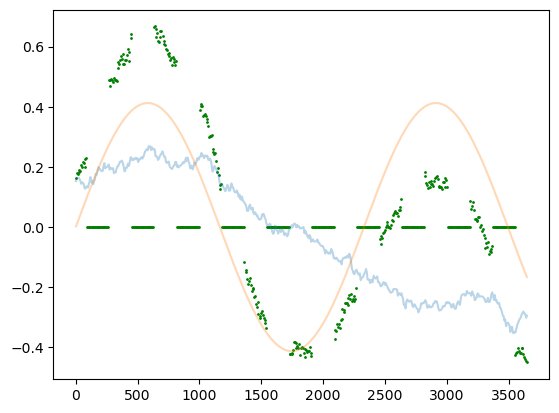

In [308]:
#main
#print(generateFixedSample())
import matplotlib.pyplot as plt
import math
light_curve = generateRandomSample() #  generateFixedSample / generateRandomSample
plt.scatter(light_curve[0], light_curve[1], 1, c='green')
plt.plot(light_curve[0], light_curve[2], alpha=0.3)
plt.plot(light_curve[0], light_curve[3], alpha=0.3)
plt.show()

In [309]:
def generateRandomSample():
     amplitude = random.uniform(0, 1)